# COVID XRAY Image Analysis

## Modeling

### Importing `libraries`

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from joblib import dump, load

### Importing `data` and creating `dataset`

(299, 299)

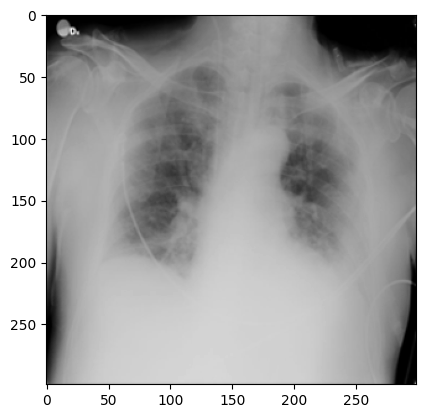

In [2]:
# looking for shape of image to reshape into dataframe

img_covid_1_gray = cv2.imread('../data/COVID/images/COVID-1.png', cv2.IMREAD_GRAYSCALE)
display(img_covid_1_gray.shape)
plt.imshow(img_covid_1_gray, cmap = 'gray');

In [3]:
pd.DataFrame(img_covid_1_gray)

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
0,185,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,24,131
1,75,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,8,42
2,11,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,3,12
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,2,9,19
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,6,16,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,55,53,63,76,88,101,114,126,133,140,...,3,13,21,4,1,1,0,0,3,5
295,66,57,65,78,90,103,116,127,135,141,...,5,17,18,2,1,1,1,3,8,8
296,78,62,68,83,95,107,119,130,138,144,...,8,21,14,1,1,1,0,3,13,27
297,104,74,75,89,100,110,122,133,140,145,...,11,22,10,0,1,1,0,1,23,83


1345

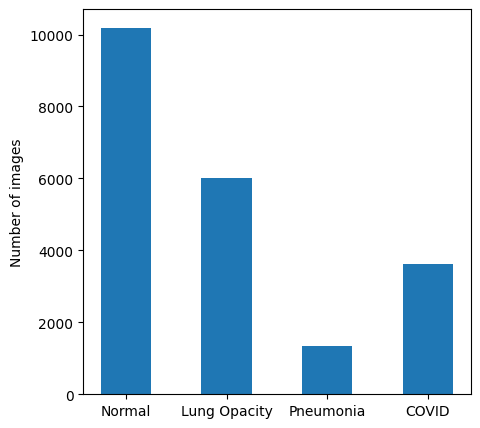

In [2]:
# looking for lowest number of images

# count of images from meta data
normal_df = pd.read_excel('../data/Normal.metadata.xlsx')
lung_opacity_df = pd.read_excel('../data/Lung_Opacity.metadata.xlsx')
viral_pneumonia_df = pd.read_excel('../data/Viral Pneumonia.metadata.xlsx')
covid_df = pd.read_excel('../data/COVID.metadata.xlsx')

count_of_images = [normal_df['FILE NAME'].count(), lung_opacity_df['FILE NAME'].count(), viral_pneumonia_df['FILE NAME'].count(), covid_df['FILE NAME'].count()]
plt.figure(figsize=(5, 5))
plt.bar(x = range(1,5), height = count_of_images, width = 0.5)
plt.ylabel('Number of images')
plt.xticks([1, 2, 3, 4], ['Normal', 'Lung Opacity', 'Pneumonia', 'COVID']);

viral_pneumonia_df['FILE NAME'].count()

In [5]:
pd.DataFrame({'Count of Images': count_of_images}, index = ['Normal', 'Lung Opacity', 'Pneumonia', 'COVID'])

,Count of Images
Normal,10192
Lung Opacity,6012
Pneumonia,1345
COVID,3616


In [3]:
# creating data out of images and labels

data_normal = pd.DataFrame()
data_lung_opacity = pd.DataFrame()
data_pneumonia = pd.DataFrame()
data_covid = pd.DataFrame()

for i in range(1,viral_pneumonia_df['FILE NAME'].count()+1):
    img_normal = cv2.imread(f'../data/Normal/images/Normal-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_normal = pd.DataFrame(img_normal.reshape([299*299])).transpose()
    row_normal['label'] = 'Normal'
    data_normal = pd.concat([data_normal, row_normal])

    img_lung_opacity = cv2.imread(f'../data/Lung_Opacity/images/Lung_Opacity-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_lung_opacity = pd.DataFrame(img_lung_opacity.reshape([299*299])).transpose()
    row_lung_opacity['label'] = 'Lung Opacity'
    data_lung_opacity = pd.concat([data_lung_opacity, row_lung_opacity])

    img_pneumonia = cv2.imread(f'../data/Viral Pneumonia/images/Viral Pneumonia-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_pneumonia = pd.DataFrame(img_pneumonia.reshape([299*299])).transpose()
    row_pneumonia['label'] = 'Pneumonia'
    data_pneumonia = pd.concat([data_pneumonia, row_pneumonia])

    img_covid = cv2.imread(f'../data/COVID/images/COVID-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_covid = pd.DataFrame(img_covid.reshape([299*299])).transpose()
    row_covid['label'] = 'COVID'
    data_covid = pd.concat([data_covid, row_covid])
    
data = pd.concat([data_normal, data_lung_opacity, data_pneumonia, data_covid])
data.index = range(len(data))
data

,0,1,2,3,4,5,6,7,8,9,...,89392,89393,89394,89395,89396,89397,89398,89399,89400,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
1,0,63,83,67,46,36,28,23,21,19,...,24,24,25,25,24,24,24,24,21,Normal
2,170,141,114,93,76,62,49,36,27,18,...,7,4,5,3,2,2,3,6,13,Normal
3,8,8,8,8,7,7,7,7,7,6,...,8,9,11,12,12,12,13,14,14,Normal
4,1,0,0,0,1,1,1,1,2,2,...,103,98,92,86,84,83,87,102,131,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,COVID
5376,132,133,139,142,142,147,162,137,115,110,...,193,185,169,158,163,149,130,125,119,COVID
5377,20,20,20,20,20,20,20,20,20,20,...,142,141,143,141,138,137,137,136,135,COVID
5378,156,154,150,144,137,132,126,119,115,111,...,132,125,119,112,103,90,74,59,49,COVID


In [51]:
data.to_csv('../data/dataset1.csv', index = False)

In [54]:
df = pd.read_csv('../data/dataset1.csv')
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,89392,89393,89394,89395,89396,89397,89398,89399,89400,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
1,1,0,63,83,67,46,36,28,23,21,...,24,24,25,25,24,24,24,24,21,Normal
2,2,170,141,114,93,76,62,49,36,27,...,7,4,5,3,2,2,3,6,13,Normal
3,3,8,8,8,8,7,7,7,7,7,...,8,9,11,12,12,12,13,14,14,Normal
4,4,1,0,0,0,1,1,1,1,2,...,103,98,92,86,84,83,87,102,131,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,5375,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,COVID
5376,5376,132,133,139,142,142,147,162,137,115,...,193,185,169,158,163,149,130,125,119,COVID
5377,5377,20,20,20,20,20,20,20,20,20,...,142,141,143,141,138,137,137,136,135,COVID
5378,5378,156,154,150,144,137,132,126,119,115,...,132,125,119,112,103,90,74,59,49,COVID


In [82]:
display(data.shape)
data.info()

(5376, 89402)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Columns: 89402 entries, 0 to label
dtypes: object(1), uint8(89401)
memory usage: 458.4+ MB


In [4]:
# separating into X and y

X = data.drop('label', axis = 1)
y = data.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})

/var/folders/_j/9jd214m51l95zvt28tkj3nvh0000gn/T/ipykernel_22138/3286871328.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
u, idx, counts = np.unique(y, axis=0, return_index=True, return_counts=True)
display(y)
display(u)
display(idx)
display(counts)

# 0: normal
# 1: lung opacity
# 2: pneumonia
# 3: covid

0       0
1       0
2       0
3       0
4       0
       ..
5371    3
5372    3
5373    3
5374    3
5375    3
Name: label, Length: 5376, dtype: int64

array([0, 1, 2, 3])

array([   0, 1344, 2688, 4032])

array([1344, 1344, 1344, 1344])

In [19]:
# split into training and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Training and Evaluation

In [10]:
# instantiating RandomForestClassifer and training it

from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [11]:
test_pred_rf = clf_rf.predict(X_test)

from sklearn.metrics import accuracy_score
rf_accuracy = accuracy_score(y_test, test_pred_rf)
rf_accuracy

0.8940520446096655

In [12]:
from sklearn.metrics import classification_report
rf_clf_report = classification_report(y_test, test_pred_rf)
print(rf_clf_report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       288
           1       0.89      0.93      0.90       267
           2       0.90      0.89      0.89       261
           3       0.89      0.88      0.89       260

    accuracy                           0.89      1076
   macro avg       0.89      0.89      0.89      1076
weighted avg       0.89      0.89      0.89      1076



[[260   6  15   7]
 [  4 243   3  17]
 [ 22   2 233   4]
 [  3  23   5 229]]


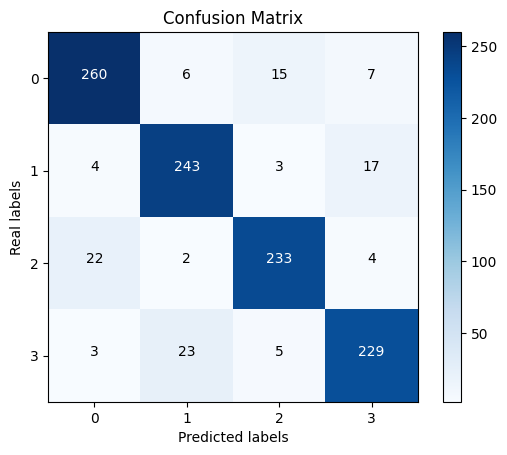

Label 2 has often been labeled as 0
Label 3 has often been labeled as 1


In [113]:
from sklearn.metrics import confusion_matrix
import itertools

#Réponse valable:
cnf_matrix = confusion_matrix(y_test, test_pred)
print(cnf_matrix)

###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
classes = range(0,4)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Real labels')
plt.xlabel('Predicted labels')
plt.show()

#####

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if(cnf_matrix[i,j] >20 and i!=j):
        print("Label {0} has often been labeled as {1}".format(i,j))

# 0: normal
# 1: lung opacity
# 2: pneumonia
# 3: covid

In [127]:
y_test

# 0: normal
# 1: lung opacity
# 2: pneumonia
# 3: covid

410     0
5295    3
2803    2
3958    2
4578    3
       ..
3493    2
802     0
4817    3
1773    1
3895    2
Name: label, Length: 1076, dtype: int64

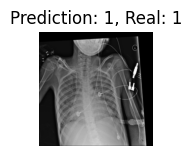

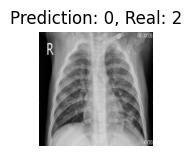

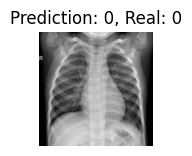

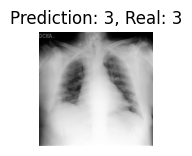

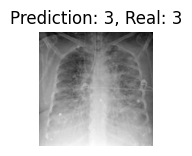

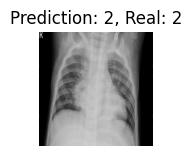

In [138]:
j = 1

for i in np.random.choice(np.arange(0, len(y_test)), size=6):
    img = X_test.iloc[i] 
    
    # Redimensionnement de l'image
    img = img.transpose().values.reshape(299, 299)
    
    figure = plt.figure(figsize=(5,5))
    # Sélection de la sous-figure
    plt.subplot(2, 3, j)
    j = j + 1
    
    # Suppression des axes
    plt.axis('off')
    
    # Affichage de l'image en niveaux de gris
    plt.imshow(img, cmap = 'gray')
    plt.title('Prediction: ' + str(test_pred[i]) + ', Real: ' + str(y_test.values[i]))

# 0: normal
# 1: lung opacity
# 2: pneumonia
# 3: covid

### Trying out different classic classification algorithms

In [3]:
# importing libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [6]:
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression()
clf_kneighbors = KNeighborsClassifier()
clf_svc = SVC()
# clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', n_jobs = -1)

In [15]:
# AdaBoostClassifier

clf_adaboost.fit(X_train, y_train)

test_pred_adaboost = clf_adaboost.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, test_pred_adaboost)
print(adaboost_accuracy)

adaboost_clf_report = classification_report(y_test, test_pred_adaboost)
print(adaboost_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.7100371747211895
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       288
           1       0.72      0.75      0.73       267
           2       0.67      0.79      0.73       261
           3       0.74      0.70      0.72       260

    accuracy                           0.71      1076
   macro avg       0.71      0.71      0.71      1076
weighted avg       0.71      0.71      0.71      1076



In [16]:
# LogisticRegression

clf_logreg.fit(X_train, y_train)

test_pred_logreg = clf_logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, test_pred_logreg)
print(logreg_accuracy)

logreg_clf_report = classification_report(y_test, test_pred_logreg)
print(logreg_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8429368029739777
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       288
           1       0.82      0.81      0.81       267
           2       0.84      0.91      0.88       261
           3       0.82      0.80      0.81       260

    accuracy                           0.84      1076
   macro avg       0.84      0.84      0.84      1076
weighted avg       0.84      0.84      0.84      1076



In [17]:
# KNeighborsClassifier

clf_kneighbors.fit(X_train, y_train)

test_pred_kneighbors = clf_kneighbors.predict(X_test)

kneighbors_accuracy = accuracy_score(y_test, test_pred_kneighbors)
print(kneighbors_accuracy)

kneighbors_clf_report = classification_report(y_test, test_pred_kneighbors)
print(kneighbors_clf_report)

0.8262081784386617
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       288
           1       0.77      0.80      0.79       267
           2       0.82      0.93      0.87       261
           3       0.78      0.76      0.77       260

    accuracy                           0.83      1076
   macro avg       0.83      0.83      0.83      1076
weighted avg       0.83      0.83      0.83      1076



In [18]:
# SVC

clf_svc.fit(X_train, y_train)

test_pred_svc = clf_svc.predict(X_test)

svc_accuracy = accuracy_score(y_test, test_pred_svc)
print(svc_accuracy)

svc_clf_report = classification_report(y_test, test_pred_svc)
print(svc_clf_report)

0.8782527881040892
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       288
           1       0.84      0.83      0.84       267
           2       0.94      0.91      0.93       261
           3       0.81      0.87      0.84       260

    accuracy                           0.88      1076
   macro avg       0.88      0.88      0.88      1076
weighted avg       0.88      0.88      0.88      1076



In [ ]:
# XGBoostClassifier

# clf_xgb.fit(X_train, y_train)

# test_pred_xgb = clf_xgb.predict(X_test)

# xgb_accuracy = accuracy_score(y_test, test_pred_xgb)
# print(xgb_accuracy)

# xgb_clf_report = classification_report(y_test, test_pred_xgb)
# print(xgb_clf_report)

In [19]:
acurracy_df = pd.DataFrame({'Accuarcy Score': [rf_accuracy, adaboost_accuracy, logreg_accuracy, kneighbors_accuracy, svc_accuracy]},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

,Accuarcy Score
RandomForest,0.894052
AdaBoost,0.710037
LogisticRegression,0.842937
KNeighbors,0.826208
SVC,0.878253


### Creating randomized dataset

In [55]:
# creating randomized data out of random images and labels

data_normal_rd = pd.DataFrame()
data_lung_opacity_rd = pd.DataFrame()
data_pneumonia = pd.DataFrame()
data_covid_rd = pd.DataFrame()

np.random.seed(42)

for i in np.random.choice(range(1,normal_df['FILE NAME'].count()+1), size = viral_pneumonia_df['FILE NAME'].count(), replace = False):
    img_normal_rd = cv2.imread(f'../data/Normal/images/Normal-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_normal_rd = pd.DataFrame(img_normal_rd.reshape([299*299])).transpose()
    row_normal_rd['label'] = 'Normal'
    row_normal_rd['Id'] = f'Normal-{i}'
    data_normal_rd = pd.concat([data_normal_rd, row_normal_rd])

for i in np.random.choice(range(1,lung_opacity_df['FILE NAME'].count()+1), size = viral_pneumonia_df['FILE NAME'].count(), replace = False):
    img_lung_opacity_rd = cv2.imread(f'../data/Lung_Opacity/images/Lung_Opacity-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_lung_opacity_rd = pd.DataFrame(img_lung_opacity_rd.reshape([299*299])).transpose()
    row_lung_opacity_rd['label'] = 'Lung Opacity'
    row_lung_opacity_rd['Id'] = f'Lung Opacity-{i}'
    data_lung_opacity_rd = pd.concat([data_lung_opacity_rd, row_lung_opacity_rd])

for i in np.random.choice(range(1,viral_pneumonia_df['FILE NAME'].count()+1), size = viral_pneumonia_df['FILE NAME'].count(), replace = False):
    img_pneumonia = cv2.imread(f'../data/Viral Pneumonia/images/Viral Pneumonia-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_pneumonia = pd.DataFrame(img_pneumonia.reshape([299*299])).transpose()
    row_pneumonia['label'] = 'Pneumonia'
    row_pneumonia['Id'] = f'Pneumonia-{i}'
    data_pneumonia = pd.concat([data_pneumonia, row_pneumonia])

for i in np.random.choice(range(1,covid_df['FILE NAME'].count()+1), size = viral_pneumonia_df['FILE NAME'].count(), replace = False):
    img_covid_rd = cv2.imread(f'../data/COVID/images/COVID-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_covid_rd = pd.DataFrame(img_covid_rd.reshape([299*299])).transpose()
    row_covid_rd['label'] = 'COVID'
    row_covid_rd['Id'] = f'COVID-{i}'
    data_covid_rd = pd.concat([data_covid_rd, row_covid_rd])
    
data_rd = pd.concat([data_normal_rd, data_lung_opacity_rd, data_pneumonia, data_covid_rd])
data_rd.index = range(len(data_rd))
data_rd

,0,1,2,3,4,5,6,7,8,9,...,89393,89394,89395,89396,89397,89398,89399,89400,label,Id
0,255,225,177,139,113,94,80,64,53,42,...,23,27,33,43,52,72,105,123,Normal,Normal-6637
1,208,83,37,34,35,35,34,33,32,32,...,26,27,26,27,27,29,32,36,Normal,Normal-3743
2,12,15,14,14,14,14,14,14,14,14,...,49,56,58,61,66,71,73,66,Normal,Normal-5115
3,10,12,14,16,18,21,22,24,24,24,...,191,167,159,152,142,129,115,105,Normal,Normal-6506
4,17,8,2,0,0,0,0,0,0,0,...,49,16,1,1,7,14,24,38,Normal,Normal-10071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,12,5,4,5,5,5,5,5,4,5,...,7,7,7,7,8,7,8,16,COVID,COVID-27
5376,197,195,195,195,196,197,196,196,197,197,...,200,200,199,198,197,197,196,196,COVID,COVID-1409
5377,83,117,119,106,101,105,107,110,109,110,...,171,165,167,167,169,169,166,174,COVID,COVID-1654
5378,66,82,97,103,104,104,103,99,97,98,...,182,179,177,173,170,167,165,165,COVID,COVID-177


In [56]:
data_rd.to_csv('../data/dataset2.csv', index = False)

In [13]:
data_rd = pd.read_csv('../data/dataset2.csv')
data_rd

,0,1,2,3,4,5,6,7,8,9,...,89393,89394,89395,89396,89397,89398,89399,89400,label,Id
0,255,225,177,139,113,94,80,64,53,42,...,23,27,33,43,52,72,105,123,Normal,Normal-6637
1,208,83,37,34,35,35,34,33,32,32,...,26,27,26,27,27,29,32,36,Normal,Normal-3743
2,12,15,14,14,14,14,14,14,14,14,...,49,56,58,61,66,71,73,66,Normal,Normal-5115
3,10,12,14,16,18,21,22,24,24,24,...,191,167,159,152,142,129,115,105,Normal,Normal-6506
4,17,8,2,0,0,0,0,0,0,0,...,49,16,1,1,7,14,24,38,Normal,Normal-10071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,12,5,4,5,5,5,5,5,4,5,...,7,7,7,7,8,7,8,16,COVID,COVID-27
5376,197,195,195,195,196,197,196,196,197,197,...,200,200,199,198,197,197,196,196,COVID,COVID-1409
5377,83,117,119,106,101,105,107,110,109,110,...,171,165,167,167,169,169,166,174,COVID,COVID-1654
5378,66,82,97,103,104,104,103,99,97,98,...,182,179,177,173,170,167,165,165,COVID,COVID-177


In [14]:
X = data_rd.drop(['label', 'Id'], axis = 1)
y = data_rd.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})

/var/folders/_j/9jd214m51l95zvt28tkj3nvh0000gn/T/ipykernel_22138/3147165207.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data_rd.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# without scaling

accuracy = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train, y_train)
    test_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, test_pred))

acurracy_df_rd = pd.DataFrame({'Accuarcy Score': accuracy},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_rd

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.820632
AdaBoost,0.625465
LogisticRegression,0.736059
KNeighbors,0.733271
SVC,0.798327


In [16]:
# with scaling

accuracy_rd = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train, y_train)
    test_pred = clf.predict(X_test)
    accuracy_rd.append(accuracy_score(y_test, test_pred))

acurracy_df_rd = pd.DataFrame({'Accuarcy Score': accuracy_rd},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_rd

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.850372
AdaBoost,0.655204
LogisticRegression,0.766729
KNeighbors,0.755576
SVC,0.822491


In [20]:
# pre-scaling

accuracy = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train, y_train)
    test_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, test_pred))

acurracy_df = pd.DataFrame({'Accuarcy Score': accuracy},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.893123
AdaBoost,0.772305
LogisticRegression,0.839219
KNeighbors,0.805762
SVC,0.868030


In [12]:
# after scaling

accuracy = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train, y_train)
    test_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, test_pred))

acurracy_df = pd.DataFrame({'Accuarcy Score': accuracy},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.886617
AdaBoost,0.772305
LogisticRegression,0.840149
KNeighbors,0.806691
SVC,0.868959


### Dimensionality Reduction

In [21]:
from sklearn.feature_selection import SelectPercentile

In [22]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,89391,89392,89393,89394,89395,89396,89397,89398,89399,89400
4200,9,9,9,9,10,10,10,10,10,10,...,183,179,179,181,175,181,185,177,165,165
3084,0,0,2,5,7,9,14,21,31,38,...,0,0,0,0,0,0,0,0,0,0
802,18,22,29,36,41,48,54,58,61,71,...,14,4,0,0,0,0,0,0,0,0
3478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1782,169,189,192,190,190,190,191,190,189,189,...,14,15,16,16,14,15,15,15,14,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,44,25,22,23,25,27,27,26,25,24,...,18,15,12,9,6,1,0,0,0,0
3772,0,0,0,0,0,0,0,0,0,0,...,18,17,17,18,18,18,18,18,18,18
5191,0,0,0,0,0,0,0,0,0,0,...,42,43,42,41,41,39,40,42,36,10
5226,198,199,199,199,199,199,199,199,199,199,...,116,110,102,95,92,88,85,84,81,77


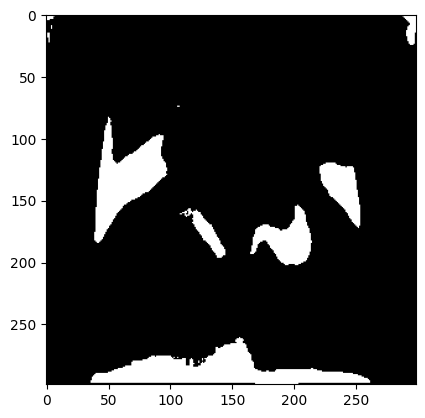

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, shuffle = True)

sel = SelectPercentile(percentile = 90)
sel.fit(X_train, y_train)

X_train_red = sel.transform(X_train)
X_test_red = sel.transform(X_test)

plt.imshow(sel.get_support().reshape(299,299), cmap = 'gray_r');

In [49]:
def plot_reduced_image(image, selector):
    mask = selector.get_support()
    #toprint = [image[i] if mask[i] == True else 0 for i in range(sum(mask))]
    fullimg = np.array([])
    cnt = 0
    for i in range(299,299):
        if mask[i]:
            fullimg = np.append(fullimg, image[i-cnt])
        else:
            fullimg = np.append(fullimg, 0)
            cnt += 1
    plt.imshow(fullimg.reshape(299,299), cmap = 'gray')

In [45]:
X_train_red

array([[ 27,  26,  27, ..., 215, 211, 215],
       [  2,   3,   3, ...,   1,   1,   1],
       [172, 167, 160, ...,  31,  31,  24],
       ...,
       [206, 204, 205, ..., 231, 230, 231],
       [ 60,  70,  68, ...,  80,  75,  59],
       [222, 219, 215, ...,  27,  25,  17]], dtype=uint8)

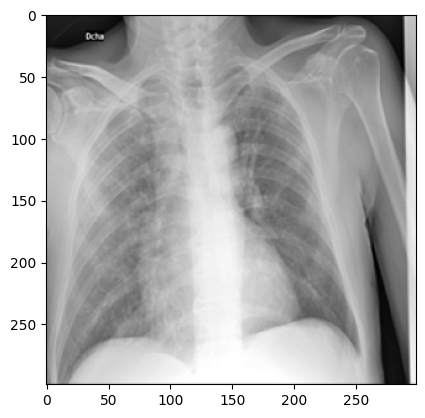

TypeError: Invalid shape (0,) for image data

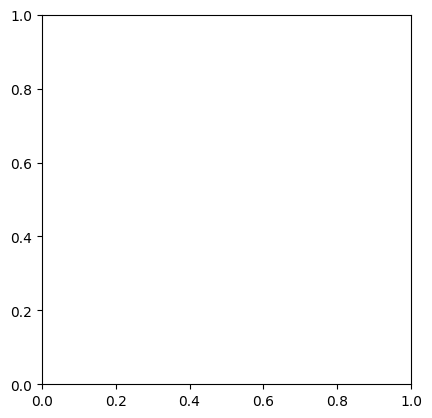

In [50]:
plt.figure()
plt.imshow(X_train.iloc[0].transpose().values.reshape(299,299), cmap = 'gray')
plt.show();
plot_reduced_image(X_train_red[0], sel)

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca = PCA(n_components = .9)
X_train_pca = pca.fit_transform(X_train_red)
X_test_pca = pca.transform(X_test_red)

print(pca.n_components_)

69


In [38]:
accuracy = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train_pca, y_train)
    test_pred = clf.predict(X_test_pca)
    accuracy.append(accuracy_score(y_test, test_pred))

acurracy_df_pca = pd.DataFrame({'Accuarcy Score': accuracy},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_pca

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.851301
AdaBoost,0.713755
LogisticRegression,0.818773
KNeighbors,0.821561
SVC,0.882900


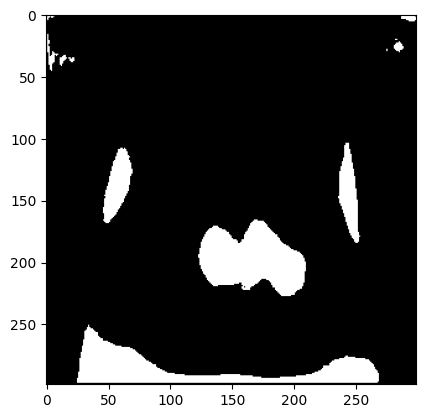

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, shuffle = True)

sel = SelectPercentile(percentile = 90)
sel.fit(X_train, y_train)

X_train_red = sel.transform(X_train)
X_test_red = sel.transform(X_test)

plt.imshow(sel.get_support().reshape(299,299), cmap = 'gray_r');

In [41]:
pca = PCA(n_components = .9)
X_train_pca_rd = pca.fit_transform(X_train_red)
X_test_pca_rd = pca.transform(X_test_red)

print(pca.n_components_)

55


In [42]:
accuracy = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train_pca_rd, y_train)
    test_pred = clf.predict(X_test_pca_rd)
    accuracy.append(accuracy_score(y_test, test_pred))

acurracy_df_pca_rd = pd.DataFrame({'Accuarcy Score': accuracy},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_pca_rd

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.764870
AdaBoost,0.603160
LogisticRegression,0.696097
KNeighbors,0.751859
SVC,0.792751


### Class Weighting, Over- & Undersampling

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [7]:
# creating unbalanced dataset with all images

data_normal_all = pd.DataFrame()
data_lung_opacity_all = pd.DataFrame()
data_pneumonia = pd.DataFrame()
data_covid_all = pd.DataFrame()

for i in range(1,normal_df['FILE NAME'].count()+1):
    img_normal_all = cv2.imread(f'../data/Normal/images/Normal-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_normal_all = pd.DataFrame(img_normal_all.reshape([299*299])).transpose()
    row_normal_all['label'] = 'Normal'
    data_normal_all = pd.concat([data_normal_all, row_normal_all])

for i in range(1,lung_opacity_df['FILE NAME'].count()+1):
    img_lung_opacity_all = cv2.imread(f'../data/Lung_Opacity/images/Lung_Opacity-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_lung_opacity_all = pd.DataFrame(img_lung_opacity_all.reshape([299*299])).transpose()
    row_lung_opacity_all['label'] = 'Lung Opacity'
    data_lung_opacity_all = pd.concat([data_lung_opacity_all, row_lung_opacity_all])

for i in range(1,viral_pneumonia_df['FILE NAME'].count()+1):
    img_pneumonia = cv2.imread(f'../data/Viral Pneumonia/images/Viral Pneumonia-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_pneumonia = pd.DataFrame(img_pneumonia.reshape([299*299])).transpose()
    row_pneumonia['label'] = 'Pneumonia'
    data_pneumonia = pd.concat([data_pneumonia, row_pneumonia])

for i in range(1,covid_df['FILE NAME'].count()+1):
    img_covid_all = cv2.imread(f'../data/COVID/images/COVID-{i}.png', cv2.IMREAD_GRAYSCALE)
    row_covid_all = pd.DataFrame(img_covid_all.reshape([299*299])).transpose()
    row_covid_all['label'] = 'COVID'
    data_covid_all = pd.concat([data_covid_all, row_covid_all])
    
data_all = pd.concat([data_normal_all, data_lung_opacity_all, data_pneumonia, data_covid_all])
data_all.index = range(len(data_all))
data_all

,0,1,2,3,4,5,6,7,8,9,...,89392,89393,89394,89395,89396,89397,89398,89399,89400,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
1,0,63,83,67,46,36,28,23,21,19,...,24,24,25,25,24,24,24,24,21,Normal
2,170,141,114,93,76,62,49,36,27,18,...,7,4,5,3,2,2,3,6,13,Normal
3,8,8,8,8,7,7,7,7,7,6,...,8,9,11,12,12,12,13,14,14,Normal
4,1,0,0,0,1,1,1,1,2,2,...,103,98,92,86,84,83,87,102,131,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21160,12,12,12,12,12,12,12,12,12,12,...,212,216,214,216,215,214,221,210,133,COVID
21161,38,38,38,38,38,38,38,38,38,38,...,143,135,122,112,109,113,130,163,196,COVID
21162,53,54,48,38,28,20,15,8,10,9,...,98,97,95,92,74,57,55,60,56,COVID
21163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,COVID


In [20]:
# Save the dataframe
data_all.to_parquet('../data/data_all.parquet')

In [7]:
# Load the dataframe
data_all = pd.read_parquet('../data/data_all.parquet')

In [ ]:
# Save the dataframe
data_all.to_hdf('../data/data_all.h5', key='df', mode='w')

# Load the dataframe with memory mapping
data_all = pd.read_hdf('../data/data_all.h5', key='df', mode='r', memory_map=True)

In [5]:
from joblib import dump, load

# Save the dataframe
dump(data_all, '../data/data_all.joblib')

# Load the dataframe
data_all = load('../data/data_all.joblib')

In [19]:
data_all.label.unique()

array(['Normal', 'Lung Opacity', 'Pneumonia', 'COVID'], dtype=object)

In [22]:
from sklearn.utils.class_weight import compute_class_weight
sample_weights = compute_class_weight(class_weight='balanced', classes=data_all.label.unique(), y = data_all.label)
sample_weights

array([0.51915718, 0.88011477, 3.93401487, 1.46328816])

In [7]:
clf_rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression(class_weight='balanced')
clf_kneighbors = KNeighborsClassifier()
clf_svc = SVC(class_weight='balanced')

In [8]:
X = data_all.drop('label', axis = 1)
y = data_all.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/_j/9jd214m51l95zvt28tkj3nvh0000gn/T/ipykernel_50315/904824387.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data_all.label.replace({'Normal': 0, 'Lung Opacity': 1, 'Pneumonia': 2, 'COVID': 3})


In [ ]:
# class-weighted

accuracy = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_train, y_train)
    test_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, test_pred))

acurracy_df_cw = pd.DataFrame({'Accuarcy Score': accuracy},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_cw

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


: 

: 

In [18]:
# RandomForestClassifier

clf_rf.fit(X_train, y_train)

test_pred_rf = clf_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, test_pred_rf)
print(rf_accuracy)

rf_clf_report = classification_report(y_test, test_pred_rf)
print(rf_clf_report)

0.8488069926765887
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      2056
           1       0.83      0.78      0.80      1191
           2       0.94      0.80      0.86       293
           3       0.90      0.79      0.84       693

    accuracy                           0.85      4233
   macro avg       0.87      0.82      0.85      4233
weighted avg       0.85      0.85      0.85      4233



In [21]:
# AdaBoostClassifier

clf_adaboost.fit(X_train, y_train)

test_pred_adaboost = clf_adaboost.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, test_pred_adaboost)
print(adaboost_accuracy)

adaboost_clf_report = classification_report(y_test, test_pred_adaboost)
print(adaboost_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.6106780061422159
              precision    recall  f1-score   support

           0       0.73      0.56      0.63      2056
           1       0.55      0.72      0.62      1191
           2       0.71      0.80      0.75       293
           3       0.45      0.51      0.48       693

    accuracy                           0.61      4233
   macro avg       0.61      0.65      0.62      4233
weighted avg       0.63      0.61      0.61      4233



In [22]:
# LogisticRegression

clf_logreg.fit(X_train, y_train)

test_pred_logreg = clf_logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, test_pred_logreg)
print(logreg_accuracy)

logreg_clf_report = classification_report(y_test, test_pred_logreg)
print(logreg_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7382471060713443
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      2056
           1       0.73      0.74      0.73      1191
           2       0.73      0.95      0.82       293
           3       0.54      0.74      0.62       693

    accuracy                           0.74      4233
   macro avg       0.71      0.78      0.74      4233
weighted avg       0.76      0.74      0.74      4233



In [10]:
# KNeighborsClassifier

clf_kneighbors.fit(X_train, y_train)

test_pred_kneighbors = clf_kneighbors.predict(X_test)

kneighbors_accuracy = accuracy_score(y_test, test_pred_kneighbors)
print(kneighbors_accuracy)

kneighbors_clf_report = classification_report(y_test, test_pred_kneighbors)
print(kneighbors_clf_report)

Python(69519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


: 

: 

In [9]:
# SVC

clf_svc.fit(X_train, y_train)

test_pred_svc = clf_svc.predict(X_test)

svc_accuracy = accuracy_score(y_test, test_pred_svc)
print(svc_accuracy)

svc_clf_report = classification_report(y_test, test_pred_svc)
print(svc_clf_report)

0.8346326482400189
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2056
           1       0.80      0.79      0.80      1191
           2       0.85      0.95      0.90       293
           3       0.74      0.83      0.78       693

    accuracy                           0.83      4233
   macro avg       0.82      0.85      0.84      4233
weighted avg       0.84      0.83      0.84      4233



In [ ]:
acurracy_df = pd.DataFrame({'Accuarcy Score': [rf_accuracy, adaboost_accuracy, logreg_accuracy, kneighbors_accuracy, svc_accuracy]},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

In [9]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)

: 

: 

In [ ]:
X_ro.shape

In [11]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

In [14]:
X_ru.shape

(4208, 89401)

In [ ]:
# oversampled training set

accuracy_ro = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_ro, y_ro)
    test_pred = clf.predict(X_test)
    accuracy_ro.append(accuracy_score(y_test, test_pred))

acurracy_df_ro = pd.DataFrame({'Accuarcy Score': accuracy_ro},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_ro

In [12]:
# undersampled training set

accuracy_ru = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_ru, y_ru)
    test_pred = clf.predict(X_test)
    accuracy_ru.append(accuracy_score(y_test, test_pred))

acurracy_df_ru = pd.DataFrame({'Accuarcy Score': accuracy_ru},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_ru

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuarcy Score
RandomForest,0.792346
AdaBoost,0.529648
LogisticRegression,0.720765
KNeighbors,0.714859
SVC,0.781243


In [15]:
# BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier()
brfc.fit(X_train, y_train)
y_pred_brfc = brfc.predict(X_test)
accuracy_score(y_test, y_pred_brfc)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/pyt

0.8112449799196787

### Training on lung area images

In [7]:
# importing raw lung area images

# Load the dataframe
raw_lung_data = load('../data/raw_lung_data.joblib')

In [18]:
raw_lung_data

,name,label,lung_image
0,Normal-6196.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Normal-7288.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Normal-1821.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Normal-4781.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Normal-4959.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
21160,Viral Pneumonia-972.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21161,Viral Pneumonia-741.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21162,Viral Pneumonia-999.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21163,Viral Pneumonia-755.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [33]:
# creating dataset of raw lung images

data_lungs_raw = pd.DataFrame()
for i in range(0,len(raw_lung_data['lung_image'])):
    image_row = pd.DataFrame(raw_lung_data['lung_image'][i][:].reshape([256*256])).transpose()
    image_row['label'] = raw_lung_data['label'][i]
    data_lungs_raw = pd.concat([data_lungs_raw, image_row])
data_lungs_raw.index = range(len(data_lungs_raw))
data_lungs_raw

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia


In [ ]:
# Save the dataframe
dump(data_lungs_raw, '../data/data_lungs_raw.joblib')

In [6]:
# Load the dataframe
data_lungs_raw = load('../data/data_lungs_raw.joblib')

In [36]:
# importing filtered lung area images

# Load the dataframe
filtered_lung_data = load('../data/filtered_lung_data.joblib')

In [37]:
filtered_lung_data

,name,label,Gau_Canny_img
0,Normal-6196.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Normal-7288.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Normal-1821.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Normal-4781.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Normal-4959.png,Normal,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
21160,Viral Pneumonia-972.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21161,Viral Pneumonia-741.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21162,Viral Pneumonia-999.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21163,Viral Pneumonia-755.png,Viral Pneumonia,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [38]:
data_lungs_filtered = pd.DataFrame()
for i in range(0,len(filtered_lung_data['Gau_Canny_img'])):
    image_row = pd.DataFrame(filtered_lung_data['Gau_Canny_img'][i][:].reshape([256*256])).transpose()
    image_row['label'] = filtered_lung_data['label'][i]
    data_lungs_filtered = pd.concat([data_lungs_filtered, image_row])
data_lungs_filtered.index = range(len(data_lungs_filtered))
data_lungs_filtered

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
21161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
21162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia
21163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Viral Pneumonia


In [39]:
# Save the dataframe
dump(data_lungs_filtered, '../data/data_lungs_filtered.joblib')

In [4]:
# Load the dataframe
data_lungs_filtered = load('../data/data_lungs_filtered.joblib')

#### Raw Lung images

In [7]:
X = data_lungs_raw.drop('label', axis = 1)
y = data_lungs_raw.label.replace({'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2, 'COVID': 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/_j/9jd214m51l95zvt28tkj3nvh0000gn/T/ipykernel_1158/425122923.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data_lungs_raw.label.replace({'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2, 'COVID': 3})


In [7]:
clf_rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression(class_weight='balanced')
clf_kneighbors = KNeighborsClassifier()
clf_svc = SVC(class_weight='balanced')

In [13]:
# RandomForestClassifier

clf_rf.fit(X_train, y_train)

test_pred_rf = clf_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, test_pred_rf)
print(rf_accuracy)

rf_clf_report = classification_report(y_test, test_pred_rf)
print(rf_clf_report)

0.7519489723600283
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      2056
           1       0.74      0.75      0.75      1185
           2       0.90      0.67      0.77       262
           3       0.80      0.32      0.46       730

    accuracy                           0.75      4233
   macro avg       0.79      0.66      0.70      4233
weighted avg       0.76      0.75      0.73      4233



In [8]:
# AdaBoostClassifier

clf_adaboost.fit(X_train, y_train)

test_pred_adaboost = clf_adaboost.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, test_pred_adaboost)
print(adaboost_accuracy)

adaboost_clf_report = classification_report(y_test, test_pred_adaboost)
print(adaboost_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.5728797543113631
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2056
           1       0.48      0.59      0.53      1185
           2       0.60      0.71      0.65       262
           3       0.36      0.12      0.18       730

    accuracy                           0.57      4233
   macro avg       0.52      0.53      0.51      4233
weighted avg       0.55      0.57      0.55      4233



In [9]:
# LogisticRegression

clf_logreg.fit(X_train, y_train)

test_pred_logreg = clf_logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, test_pred_logreg)
print(logreg_accuracy)

logreg_clf_report = classification_report(y_test, test_pred_logreg)
print(logreg_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6269785022442712
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      2056
           1       0.60      0.60      0.60      1185
           2       0.66      0.82      0.73       262
           3       0.37      0.45      0.40       730

    accuracy                           0.63      4233
   macro avg       0.60      0.64      0.61      4233
weighted avg       0.64      0.63      0.63      4233



In [10]:
# KNeighborsClassifier

clf_kneighbors.fit(X_train, y_train)

test_pred_kneighbors = clf_kneighbors.predict(X_test)

kneighbors_accuracy = accuracy_score(y_test, test_pred_kneighbors)
print(kneighbors_accuracy)

kneighbors_clf_report = classification_report(y_test, test_pred_kneighbors)
print(kneighbors_clf_report)

0.6813134892511221
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      2056
           1       0.64      0.63      0.64      1185
           2       0.90      0.66      0.76       262
           3       0.51      0.27      0.35       730

    accuracy                           0.68      4233
   macro avg       0.69      0.61      0.63      4233
weighted avg       0.67      0.68      0.66      4233



In [11]:
# SVC

clf_svc.fit(X_train, y_train)

test_pred_svc = clf_svc.predict(X_test)

svc_accuracy = accuracy_score(y_test, test_pred_svc)
print(svc_accuracy)

svc_clf_report = classification_report(y_test, test_pred_svc)
print(svc_clf_report)

0.7550200803212851
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      2056
           1       0.74      0.75      0.74      1185
           2       0.81      0.89      0.85       262
           3       0.54      0.57      0.56       730

    accuracy                           0.76      4233
   macro avg       0.73      0.75      0.74      4233
weighted avg       0.76      0.76      0.76      4233



In [14]:
acurracy_df = pd.DataFrame({'Accuarcy Score': [rf_accuracy, adaboost_accuracy, logreg_accuracy, kneighbors_accuracy, svc_accuracy]},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

,Accuarcy Score
RandomForest,0.751949
AdaBoost,0.572880
LogisticRegression,0.626979
KNeighbors,0.681313
SVC,0.755020


#### Filtered Lung Images

In [5]:
X = data_lungs_filtered.drop('label', axis = 1)
y = data_lungs_filtered.label.replace({'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2, 'COVID': 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/_j/9jd214m51l95zvt28tkj3nvh0000gn/T/ipykernel_38733/323237619.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data_lungs_filtered.label.replace({'Normal': 0, 'Lung_Opacity': 1, 'Viral Pneumonia': 2, 'COVID': 3})


In [16]:
clf_rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced')
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression(class_weight='balanced')
clf_kneighbors = KNeighborsClassifier()
clf_svc = SVC(class_weight='balanced')

In [17]:
# RandomForestClassifier

clf_rf.fit(X_train, y_train)

test_pred_rf = clf_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, test_pred_rf)
print(rf_accuracy)

rf_clf_report = classification_report(y_test, test_pred_rf)
print(rf_clf_report)

0.5802031656035909
              precision    recall  f1-score   support

           0       0.57      0.92      0.70      2056
           1       0.59      0.38      0.46      1185
           2       0.85      0.22      0.35       262
           3       0.77      0.07      0.12       730

    accuracy                           0.58      4233
   macro avg       0.70      0.40      0.41      4233
weighted avg       0.63      0.58      0.51      4233



In [18]:
# AdaBoostClassifier

clf_adaboost.fit(X_train, y_train)

test_pred_adaboost = clf_adaboost.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, test_pred_adaboost)
print(adaboost_accuracy)

adaboost_clf_report = classification_report(y_test, test_pred_adaboost)
print(adaboost_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.5036617056461139
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      2056
           1       0.42      0.52      0.46      1185
           2       0.38      0.39      0.39       262
           3       0.38      0.03      0.05       730

    accuracy                           0.50      4233
   macro avg       0.44      0.40      0.38      4233
weighted avg       0.48      0.50      0.46      4233



In [19]:
# LogisticRegression

clf_logreg.fit(X_train, y_train)

test_pred_logreg = clf_logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, test_pred_logreg)
print(logreg_accuracy)

logreg_clf_report = classification_report(y_test, test_pred_logreg)
print(logreg_clf_report)

0.6293408929836996
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2056
           1       0.56      0.58      0.57      1185
           2       0.77      0.69      0.73       262
           3       0.43      0.32      0.37       730

    accuracy                           0.63      4233
   macro avg       0.62      0.59      0.60      4233
weighted avg       0.62      0.63      0.62      4233



In [20]:
# KNeighborsClassifier

clf_kneighbors.fit(X_train, y_train)

test_pred_kneighbors = clf_kneighbors.predict(X_test)

kneighbors_accuracy = accuracy_score(y_test, test_pred_kneighbors)
print(kneighbors_accuracy)

kneighbors_clf_report = classification_report(y_test, test_pred_kneighbors)
print(kneighbors_clf_report)

0.28395936687928186
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2056
           1       0.28      1.00      0.44      1185
           2       0.00      0.00      0.00       262
           3       1.00      0.02      0.04       730

    accuracy                           0.28      4233
   macro avg       0.57      0.26      0.12      4233
weighted avg       0.74      0.28      0.13      4233



/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages

In [21]:
# SVC

clf_svc.fit(X_train, y_train)

test_pred_svc = clf_svc.predict(X_test)

svc_accuracy = accuracy_score(y_test, test_pred_svc)
print(svc_accuracy)

svc_clf_report = classification_report(y_test, test_pred_svc)
print(svc_clf_report)

0.6692652964800379
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      2056
           1       0.59      0.68      0.63      1185
           2       0.76      0.66      0.70       262
           3       0.51      0.32      0.40       730

    accuracy                           0.67      4233
   macro avg       0.65      0.61      0.62      4233
weighted avg       0.66      0.67      0.66      4233



In [22]:
acurracy_df = pd.DataFrame({'Accuarcy Score': [rf_accuracy, adaboost_accuracy, logreg_accuracy, kneighbors_accuracy, svc_accuracy]},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

,Accuarcy Score
RandomForest,0.580203
AdaBoost,0.503662
LogisticRegression,0.629341
KNeighbors,0.283959
SVC,0.669265


#### Random Oversampling

In [9]:
# Oversampling with raw images

rOs = RandomOverSampler()
X_ro_raw, y_ro_raw = rOs.fit_resample(X_train, y_train)

# took 49m 14.8s

In [10]:
print(X_ro_raw.shape)
print(y_ro_raw.shape)

(32544, 65536)
(32544,)


In [11]:
# Save the dataframe
dump(X_ro_raw, '../data/X_ro_raw.joblib')
dump(y_ro_raw, '../data/y_ro_raw.joblib')

['../data/y_ro_raw.joblib']

In [3]:
# Load the dataframe
X_ro_raw = load('../data/X_ro_raw.joblib')
y_ro_raw = load('../data/y_ro_raw.joblib')

In [12]:
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression(n_jobs=-1)
clf_kneighbors = KNeighborsClassifier(n_jobs=-1)
clf_svc = SVC()

In [13]:
# RandomForestClassifier

clf_rf.fit(X_ro_raw, y_ro_raw)

test_pred_rf = clf_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, test_pred_rf)
print(rf_accuracy)

rf_clf_report = classification_report(y_test, test_pred_rf)
print(rf_clf_report)

#took 65m 47.5s

0.764942121426884
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      2056
           1       0.74      0.77      0.75      1185
           2       0.85      0.76      0.80       262
           3       0.68      0.44      0.54       730

    accuracy                           0.76      4233
   macro avg       0.76      0.71      0.73      4233
weighted avg       0.76      0.76      0.76      4233



In [6]:
# Oversampling with filtered images

rOs = RandomOverSampler()
X_ro_filtered, y_ro_filtered = rOs.fit_resample(X_train, y_train)

# took 42m 26.3s

In [11]:
print(X_ro_filtered.shape)
print(y_ro_filtered.shape)

(32544, 65536)
(32544,)


In [9]:
# Save the dataframe
dump(X_ro_filtered, '../data/X_ro_filtered.joblib')
dump(y_ro_filtered, '../data/y_ro_filtered.joblib')

['../data/X_ro_filtered.joblib']

In [ ]:
# Load the dataframe
X_ro_filtered = load('../data/X_ro_filtered.joblib')
y_ro_filtered = load('../data/y_ro_filtered.joblib')

In [14]:
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression(n_jobs=-1)
clf_kneighbors = KNeighborsClassifier(n_jobs=-1)
clf_svc = SVC()

In [15]:
# RandomForestClassifier

clf_rf.fit(X_ro_filtered, y_ro_filtered)

test_pred_rf = clf_rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, test_pred_rf)
print(rf_accuracy)

rf_clf_report = classification_report(y_test, test_pred_rf)
print(rf_clf_report)

#took 258m 9.4s

0.6005197259626742
              precision    recall  f1-score   support

           0       0.60      0.87      0.71      2056
           1       0.57      0.48      0.52      1185
           2       0.73      0.42      0.53       262
           3       0.66      0.12      0.20       730

    accuracy                           0.60      4233
   macro avg       0.64      0.47      0.49      4233
weighted avg       0.61      0.60      0.56      4233



In [ ]:
# AdaBoostClassifier

clf_adaboost.fit(X_ro_filtered, y_ro_filtered)

test_pred_adaboost = clf_adaboost.predict(X_test)

adaboost_accuracy = accuracy_score(y_test, test_pred_adaboost)
print(adaboost_accuracy)

adaboost_clf_report = classification_report(y_test, test_pred_adaboost)
print(adaboost_clf_report)

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.5036617056461139
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      2056
           1       0.42      0.52      0.46      1185
           2       0.38      0.39      0.39       262
           3       0.38      0.03      0.05       730

    accuracy                           0.50      4233
   macro avg       0.44      0.40      0.38      4233
weighted avg       0.48      0.50      0.46      4233



In [ ]:
# LogisticRegression

clf_logreg.fit(X_ro_filtered, y_ro_filtered)

test_pred_logreg = clf_logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, test_pred_logreg)
print(logreg_accuracy)

logreg_clf_report = classification_report(y_test, test_pred_logreg)
print(logreg_clf_report)

0.6293408929836996
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2056
           1       0.56      0.58      0.57      1185
           2       0.77      0.69      0.73       262
           3       0.43      0.32      0.37       730

    accuracy                           0.63      4233
   macro avg       0.62      0.59      0.60      4233
weighted avg       0.62      0.63      0.62      4233



In [ ]:
# KNeighborsClassifier

clf_kneighbors.fit(X_ro_filtered, y_ro_filtered)

test_pred_kneighbors = clf_kneighbors.predict(X_test)

kneighbors_accuracy = accuracy_score(y_test, test_pred_kneighbors)
print(kneighbors_accuracy)

kneighbors_clf_report = classification_report(y_test, test_pred_kneighbors)
print(kneighbors_clf_report)

0.28395936687928186
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2056
           1       0.28      1.00      0.44      1185
           2       0.00      0.00      0.00       262
           3       1.00      0.02      0.04       730

    accuracy                           0.28      4233
   macro avg       0.57      0.26      0.12      4233
weighted avg       0.74      0.28      0.13      4233



/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages

In [ ]:
# SVC

clf_svc.fit(X_ro_filtered, y_ro_filtered)

test_pred_svc = clf_svc.predict(X_test)

svc_accuracy = accuracy_score(y_test, test_pred_svc)
print(svc_accuracy)

svc_clf_report = classification_report(y_test, test_pred_svc)
print(svc_clf_report)

0.6692652964800379
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      2056
           1       0.59      0.68      0.63      1185
           2       0.76      0.66      0.70       262
           3       0.51      0.32      0.40       730

    accuracy                           0.67      4233
   macro avg       0.65      0.61      0.62      4233
weighted avg       0.66      0.67      0.66      4233



In [ ]:
acurracy_df = pd.DataFrame({'Accuarcy Score': [rf_accuracy, adaboost_accuracy, logreg_accuracy, kneighbors_accuracy, svc_accuracy]},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df

,Accuarcy Score
RandomForest,0.580203
AdaBoost,0.503662
LogisticRegression,0.629341
KNeighbors,0.283959
SVC,0.669265
